In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/home/mrigank/miniconda3/envs/fast/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict teh next one
X, Y = [], []
for w in words[:5]:
    
    print(w)
    context = [0] * block_size # padding with .'s of block_size count
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # crop & append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [9]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [ ]:
# Let's try to map 27 characters into a 2 dimensional space

C = torch.randn((27,2))

#### Before trying to embed all integers in "X", let's try embedding a single integer, say - 5

In [ ]:
# One way could be just index into 5th row of C
C[5]

In [ ]:
# Other way could be doing 
# "dot" multiplication of One-Hot vector of 5 (made with 27 classes)
# with C

F.one_hot(torch.tensor(5), num_classes=27).float() @ C

# This gives exact same thing as above

### Above - there are 2 things to be learnt
1. When direct indexing into matrix C
    - It can be seen as the embedding matrix of characters
    - Those embeddings of corresponding chars can be fed into the first layer of the network
2. Instead, we can take **One-Hot** repr of characters:
    - Matrix multiply them to C, which can be thought of as weights of first layer (also called embed layer)
    - The result of this would be identical to the approach 1.

### We're going to just use the 1st approach, index into the C to get embeddings

In [ ]:
# It is not straight forward to index simultaneoudly for (32,3) matrix of integers from C
# We have to use pytorch indexing 

# We can index using list

C[[5,6,7]]

In [ ]:
# PyTorch indexing also works with tensor

C[torch.tensor([5,6,7])]

In [ ]:
# WE can also repeat a row multiple times

C[torch.tensor([5,6,7,7,7])]

In [ ]:
# Importantly, we can also index with multi-dimensional tensor

C[X]

In [ ]:
C[X].shape

# This way we can embed all integers in X into 2 dimensional embeddings

In [ ]:
X[13,2]

In [ ]:
C[X][13,2]

In [ ]:
# above is same as
C[1]

In [ ]:
emb = C[X]
emb.shape

In [ ]:
W1 = torch.randn((6,100)) #6 - 2-d embeddings for 3 ; 100 - number of neurons taken in 1st hidden layer
b1 = torch.randn(100)

In [ ]:
# Now we would ideally want to do "Wx + b"

# emb @ W1 + b1

# But this would not directly work

- We need to transform the tensor **emb** into a form
    - such that **matrix multiplication** can work with **W1**

In [ ]:
# Two ways to do it are shown here:

emb.view(32,6) == torch.cat(torch.unbind(emb, 1), 1)

In [ ]:
emb.view(32,6).shape, torch.cat(torch.unbind(emb, 1), 1).shape

In [ ]:
# Hence, we can do Wx + b as this

# emb.view(32,6) @ W1 + b1
#This has a problem that we are hard-coding first dimenssion

In [ ]:
# Other ways to do the transformation are:

print(emb.view(emb.shape[0], 6).shape)
# or
print(emb.view(-1, 6).shape) # This just calculates what must be the number of first dimension, given the second

In [ ]:
# Therefore: we now calculate hidden layer activations

h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

In [ ]:
h

In [ ]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
logits.shape

In [ ]:
counts = logits.exp()
counts.shape

In [ ]:
(counts.sum(1, keepdim=True)).shape

In [ ]:
probs = counts / counts.sum(1, keepdim=True)
probs.shape

In [ ]:
Y

In [ ]:
Y.shape

### Now we,
    - index into rows of probs
        - and pluck out probabilities assigned to the correct character

In [ ]:
probs[torch.arange(32), Y]

In [ ]:
loss = probs[torch.arange(32), Y].log().mean()
loss

In [ ]:
# --------------------- Doing all of above: TOGETHER --------------------------------

In [ ]:
X.shape, Y.shape

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
# Total parameters in model
sum(p.nelement() for p in parameters)

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
for _ in range(1000):

    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    # ------------Below 3 lines can be very efficiently done with PyTorch in-built function----
    # Also F.cross_entropy can be more efficient in forward, backward passes & numerically much well behaved
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = probs[torch.arange(32), Y].log().mean()
    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad

### We are so easily able to overfit 
    - Coz we have so less data samples (32) to train with
        - And we have a lot parameters (~4000) as per data count
    - We are able to reduce to 0, but not there yet
        - Coz, the starting data from every word --> '...' ----> e/o/... are not very deterministic to learn for model

In [10]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict teh next one
X, Y = [], []
for w in words:
    
#     print(w)
    context = [0] * block_size # padding with .'s of block_size count
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # crop & append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [11]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
# Total parameters in model
sum(p.nelement() for p in parameters)

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
for _ in range(100):

    # forward pass
    emb = C[X] # (228146, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y)
#     print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad

1. Here we see, significant time taken for each epoch
    - Which is due to us doing backprop once for entire data, which is big now.
    - So we should think of trying **mini batch**
        - We select some portion of dataset -> called **mini batch**
            - Then do forward, backward and updates on that mini batch
        - Repeat above for other portions (or mini batches)

In [ ]:
torch.randint(0, X.shape[0], (32,))
# getting tensor of 32 (which is our batch_size) integers between (0, number of samples in X)

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
for _ in range(5000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2) again it becomes a batch of size 32
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
#     print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad
        
print(loss.item())

In [ ]:
emb = C[X] # (32, 3, 2) again it becomes a batch of size 32
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)

loss # Looking at the loss on entire training data after some training

1. But the training is much faster
2. Now, due to minibatch, quality of our gradients is not as good
    - coz, direction of gradient is not as good as when calculating over entire dataset
    - Meanwhile, in the start, the approximate direction with more steps (faster) is important than correct direction and lesser steps (slower)

### Finding a decent Learning Rate

In [ ]:
lre = torch.linspace(-3, 0, 1000) # learning rate exponents - will give 1000 mumbers b/w (-3, 0)
lrs = 10**lre

In [ ]:
# lrs

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
lri = []
lossi = []

for i in range(1000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2) again it becomes a batch of size 32
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lr)
    lossi.append(loss.item())
        
# print(loss.item())

In [ ]:
plt.plot(lri, lossi)

In [ ]:
plt.plot(lre, lossi)

### These plots show --> Learning Rate around ~0.1 / LR exponent around -1 are getting best losses

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,100), generator = g)
b1 = torch.randn(100, generator = g)
W2 = torch.randn((100,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [ ]:
# lri = []
# lossi = []

for i in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2) again it becomes a batch of size 32
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
#     print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
#     lr = lrs[i]
    lr = 1e-1
    for p in parameters:
        p.data += -lr * p.grad
        
#     # track stats
#     lri.append(lr)
#     lossi.append(loss.item())
        
# print(loss.item())

In [ ]:
emb = C[X] # (32, 3, 2) again it becomes a batch of size 32
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)

loss # Looking at the loss on entire training data after some training

### We have surpassed bi-gram LM loss already, with around 40,000 epochs

#### Once the loss reduction slows down, we try WEIGHT DECAY

In [ ]:
for i in range(10000):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2) again it becomes a batch of size 32
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
#     print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = 1e-2
    for p in parameters:
        p.data += -lr * p.grad

# print(loss.item())

In [ ]:
emb = C[X] # (32, 3, 2) again it becomes a batch of size 32
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)

loss # Looking at the loss on entire training data after some training

This is summary of how things go in training a model
 - We find a decent learning rate to start with (do a bit of training)
 - Do WEIGHT DECAY (say by a factor of 10) - and train again for a bit
 
And we have a trained model

---

### Moving on to train / test splits

1. Above we had neural net with only ~4000 parameters, but as we go along and our parameters scale up
    - The overfitting chances skyrocket (if data is not too big)
        - Therefore, the very low **loss** on train data will not imply good performance
            - Instead, it would mean the model started memorizing the data
2. To remedy this, we has to have a held out set to evaluate performance of our models post training.
    - training split, dev/validation split, test split
        - 80%, 10%, 10%
3. **Training split** - is to train the model parameters
4. **Dev/validation split** - to train model hyper-parameters
5. **Test split** - to test model performance
    - But we must **NOT** evaluate loss of the model on **test split** frequently.
        - Coz everytime you evaluate on test split and learn something from it
            - then the model starts learning from this data as well

In [12]:
def build_dataset(words):

    block_size = 3 # context length: how many characters do we take to predict teh next one
    X, Y = [], []
    for w in words:
        context = [0] * block_size # padding with .'s of block_size count
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix] # crop & append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [55]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator = g)
W1 = torch.randn((6,300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [56]:
# Total parameters in model
sum(p.nelement() for p in parameters)

10281

In [57]:
for p in parameters:
    p.requires_grad = True

In [78]:
lri = []
lossi = []
stepi = []

for i in range(30000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2) again it becomes a batch of size 32
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepi.append(i)
    lossi.append(loss.item())
        
# print(loss.item())

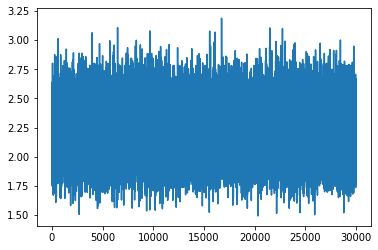

In [79]:
plt.plot(stepi, lossi)

In [80]:
emb = C[Xtr] # (32, 3, 2) again it becomes a batch of size 32
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)

loss # Looking at the loss on entire training data after some training

tensor(2.2107, grad_fn=<NllLossBackward0>)

In [81]:
emb = C[Xdev] # (32, 3, 2) again it becomes a batch of size 32
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)

loss # Looking at the loss on entire training data after some training

tensor(2.2240, grad_fn=<NllLossBackward0>)

### Before moving on to address the bottleneck of low dimensions of embeddings
    - Let's visualize the embeddings in 2-d

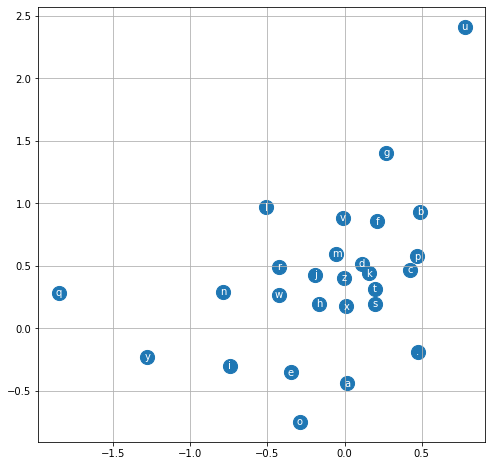

In [82]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

### Now let's try with more number of embedding dimensions

In [111]:
C = torch.randn((27, 20), generator=g)
W1 = torch.randn((60, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

18167

In [112]:
for p in parameters:
    p.requires_grad = True

In [113]:
lri = []
lossi = []
stepi = []

In [114]:
for i in range(200000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 60) @ W1 +b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
#     lr = 0.01
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
    # we are using log10 here to squash the hockey stick appearance of plot; prints log-loss

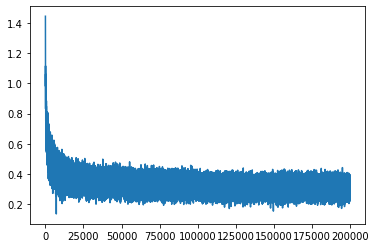

In [115]:
plt.plot(stepi, lossi)

In [116]:
# Loss over training set

emb = C[Xtr] # (32, 3, 2) again it becomes a batch of size 32
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)

loss # Looking at the loss on entire training data after some training

tensor(2.0557, grad_fn=<NllLossBackward0>)

In [117]:
# Loss over dev set

emb = C[Xdev] # (32, 3, 2) again it becomes a batch of size 32
h = torch.tanh(emb.view(-1, 60) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)

loss # Looking at the loss on entire training data after some training

tensor(2.1433, grad_fn=<NllLossBackward0>)